# TP 2: Neural networks (2)

**Execute this cell first to load the dependencies (this will create files in your current working directory).**

In [1]:
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

resp = urlopen('https://drive.google.com/uc?export=download&id=1gkQyKUWncSEgqwSpGlRvBb_gZO95ku7U')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.extractall()

In [2]:
from IPython.display import clear_output, display
from ipywidgets import Output

In [3]:
!pip install livelossplot
clear_output()

In [4]:
from livelossplot import PlotLossesKerasTF
from tqdm.keras import TqdmCallback

In [5]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print("In Colab?", IN_COLAB)

In Colab? True


In [6]:
if IN_COLAB:
    !pip install pretty_midi pyfluidsynth
    !apt-get install fluidsynth

    from IPython.display import Audio, display
    from pretty_midi import PrettyMIDI
    clear_output()

## 2. Jazz improvisation with recurrent neural networks

In this exercise, we will train a recurrent neural network in order to generate jazz music. Our network is trained on an existing jazz melody, and it learns to predict the next note based on the history of notes. Once the network is trained, we can use it to generate a new sequence of notes to in order to generate a piece of music.

Note: for this exercise you will need to install one extra module for music processing, called `music21`. You can install this module using `pip`, either within the Jupyter notebook or on the Acaconda prompt.

In [7]:
!pip install music21
clear_output(wait=True)

Recurrent neural networks are perfectly suited for processing sequential information. In a traditional neural network we assume that all inputs (and outputs) are independent of each other, but this is not the case for  sequences. For example, in order to predict the next word in a sentence you need to know which words came before. RNNs are called recurrent because they perform the same task for every element of a sequence, producing an output based on the previous computations. Another way to think about RNNs is that they have a "memory" which captures information about what has been calculated so far. A graphical representation is given in the figure below. 

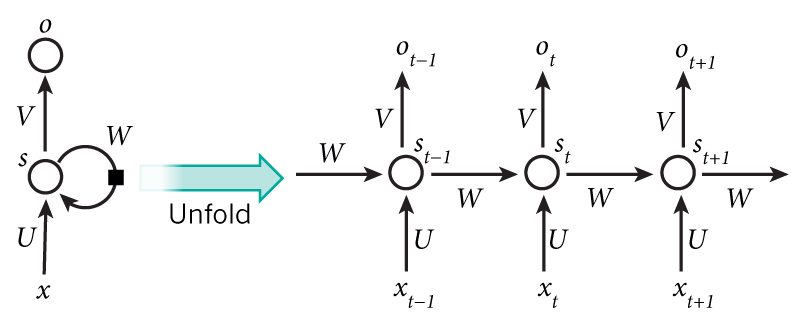

The picture on the left shows the neural network with recurrent connection; the picture on the right shows the same recurrent network, "unrolled" for three different timesteps. For music generation the process is as follows: at each timestep, the current note in a sequence is submitted to the neural network. This note is represented as a one-hot vector: say that we have a set of 7 notes, $[do, re, mi, fa, sol, la, ti]$. The one-hot vector representation of $mi$ would then be $[0 0 1 0 0 0 0]$, i.e. all-zero, except for the position of the correct note. The recurrent neural network combines the current note with the representation of the context history (the preceding notes) in order to construct a representation for the current timestep. The representation of the current timestep may then be used for the prediction of the note in the next timestep (which can then be submitted to the network again in order to repeat the process).

Note that a number of more evolved recurrent architectures exist, such as long short term memory (LSTM) networks and gated recurrent unit (GRU) networks. These architectures allow us to more precisely model complex interactions between events that occur several timesteps apart.

Let's see how we can implement such a recurrent neural network for jazz improvisation. First, we'll import a number of necessary modules and helper functions.

In [8]:
from __future__ import print_function
from music21 import *
import numpy as np
from data_utils import *
import matplotlib.pyplot as plt

Next, we'll load the necessary data files. $X$ and $y$ represent our training data, the remaining files are used for music generation according to the predictions of the network.

In [9]:
(X, y, n_values, chords,
 abstract_grammars, corpus, tones, 
 tones_indices, indices_tones) = load_music_data()

In [10]:
n_train = X.shape[0]
n_timesteps = X.shape[1]

print('number of training examples:', n_train)
print('Tx (length of sequence):', n_timesteps)
print('total # of unique values:', n_values)

number of training examples: 58
Tx (length of sequence): 20
total # of unique values: 78


Our data consists of 58 training examples. Each training example in $X$ is represented by a 20x78 matrix. This matrix represents a sequence of 20 notes, and each of the 20 notes can be one of 78 possibilities (represented as a one-hot vector).


In [11]:
print('shape of X:', X.shape)

shape of X: (58, 20, 78)


Each label in $y$ is a 78-valued one hot vector, representing the note that follows the 20 notes represented in X. The goal of the network is to predict the correct note in y given the 20 notes that precede it.


In [12]:
print('Shape of Y:', y.shape)

Shape of Y: (58, 78)


We will predict the correct note using a recurrent neural network. The RNN processes the sequence of 20 notes, which results in a hidden representation of the sequence. The hidden representation is then propagated to a dense layer with softmax activation, resulting in a probability distribution over the 78 possibilities for the next note.


In [13]:
model = keras.Sequential([
    # Si vous voulez empiler des RNN, il faut passer return_sequences=True aux couches inférieures
    # pour qu'elles renvoient leurs sorties en séquences, et pas seulement l'état final
    # par ex:
    # keras.layers.LSTM(32, input_shape=(n_timesteps, n_values), return_sequences=True),
    keras.layers.LSTM(32, input_shape=(n_timesteps, n_values)),
    keras.layers.Dense(n_values, activation = 'softmax')
])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                14208     
_________________________________________________________________
dense (Dense)                (None, 78)                2574      
Total params: 16,782
Trainable params: 16,782
Non-trainable params: 0
_________________________________________________________________


Once our model is defined, we compile it.

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop')

 And finally, we fit it to our data.

In [16]:
PLOT_CONTEXT = Output()
display(PLOT_CONTEXT)

from livelossplot.inputs.tf_keras import PlotLossesCallback
from typing import Dict
class PLK(PlotLossesCallback):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def on_epoch_end(self, epoch: int, logs: Dict[str, float]):
        with PLOT_CONTEXT:
            super().on_epoch_end(epoch, logs)

Output()

In [17]:
history = model.fit(X, y, batch_size=10, epochs=100, verbose=0, callbacks=[PLK(), TqdmCallback()])

Once our model is fitted, we can use it to predict sequences of notes. These sequences are then used by the function below in order to generate some jazz improvisation. The function below equally applies a number of post-processing steps, which are beyond the scope of this practical session.


In [18]:
out_stream = generate_music(model, chords, abstract_grammars,
                            corpus, tones, tones_indices,
                            indices_tones, X)

Predicting new values for different set of chords.
Generated 50 sounds (chord 1)
Generated 49 sounds (chord 2)
Generated 51 sounds (chord 3)
Generated 51 sounds (chord 4)
Generated 50 sounds (chord 5)
Your generated music is saved in output/my_music.midi


The code above generates a midi file in the directory $output$, based on the predictions of the network. The code below should display a widget to listen to the generated music.

In [19]:
midi_file = 'output/my_music.midi'

if IN_COLAB:
    music = PrettyMIDI(midi_file=midi_file)
    waveform = music.fluidsynth()
    display(Audio(waveform, rate=44100))
else:
    mf = midi.MidiFile()
    mf.open(midi_file)
    mf.read()
    mf.close()
    s = midi.translate.midiFileToStream(mf)
    s.show('midi')

Alternatively, you can use a midi player available on your computer to play the file, or if you don't have a midi player, you can use an online conversion tool that converts midi to mp3. Does the result sound convincing?

### Exercise

Try to improve the neural network's performance. Try a GRU instead of an LSTM. Try to change the hidden representation size. Experiment with an extra recurrent layer. How does this change the loss? Is the resulting music better?